In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd

from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

import lpips
import face_alignment
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

from LoadData import CelebADataset, Rescale,ToTensor, imshow, ObfuscaionToTensor

from sklearn.utils import shuffle


# train_on_gpu = 0
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    device='cpu'
    print('CUDA is not available.')
else:
    device='cuda'
    print('CUDA is available.')

CUDA is available.


In [2]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
from skimage.filters import threshold_isodata, threshold_mean, try_all_threshold, unsharp_mask, wiener, LPIFilter2D
from skimage.filters import gaussian, median, laplace, scharr, meijering, inverse, roberts, sato, rank_order
from skimage.filters.rank import mean_percentile
from skimage.transform import rescale, resize, downscale_local_mean
from skimage.util import img_as_float, random_noise
from skimage.morphology import disk
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

class CelebADataset(Dataset):
  

    def __init__(self, data_frame, transform=None,obfuscation=False, Grayscale = False, sigma=0):

        self.data_frame = data_frame
        self.transform = transform
        self.obfuscation = obfuscation
        self.sigma = sigma
        self.Grayscale = Grayscale

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        if self.obfuscation:
            if self.Grayscale:
                image = io.imread(self.data_frame.iloc[idx, 1], as_gray=True) 
            else:
                image = io.imread(self.data_frame.iloc[idx, 1])          
#             image = image.tolist()
#             image= np.asarray(image, dtype="int32" )
#             obfus_image = random_noise(image, var=1)
#             obfus_image = swirl(image, rotation=0, strength=10, radius=120)
            obfus_image = resize(image, (7, 7),
                       anti_aliasing=True)
#             obfus_image = gaussian(image, sigma=self.sigma, multichannel=True)
#             obfus_image = median(image, disk(12))
#             obfus_image = laplace(image, ksize=3, mask=None)
#             obfus_image = unsharp_mask(image, radius=12)
#             obfus_image = rank_order(image)
            labels = self.data_frame.iloc[idx, 0]
            labels = np.array(labels)
            labels = labels.astype(np.float)
            sample = {'image': image,'obfuscated': obfus_image, 'labels': labels}
           
        else:     
            if self.Grayscale:
                image = io.imread(self.data_frame.iloc[idx, 1], as_gray=True) 
            else:
                image = io.imread(self.data_frame.iloc[idx, 1])
            labels = self.data_frame.iloc[idx, 0]
            labels = np.array(labels)
            labels = labels.astype(np.float)
            sample = {'image': image, 'labels': labels}

        if self.transform:
            sample = self.transform(sample)
        return sample
    


class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size_height,output_size_width,obfuscation=False):
        assert isinstance(output_size_height, (int, tuple))
        assert isinstance(output_size_width, (int, tuple))
        self.output_size_height = output_size_height
        self.output_size_width = output_size_width
        self.obfuscation = obfuscation

    def __call__(self, sample):
        
            
              
        new_h, new_w = self.output_size_height,self.output_size_width
        new_h, new_w = int(new_h), int(new_w)
        if self.obfuscation:
            image, obfus_image, labels = sample['image'],sample['obfuscated'], sample['labels']
            obfus_image = transform.resize(obfus_image, (new_h, new_w))
            img = transform.resize(image, (new_h, new_w))
            return {'image': img,'obfuscated': obfus_image, 'labels': labels}
        else:
            image, labels = sample['image'], sample['labels']
            img = transform.resize(image, (new_h, new_w))
            return {'image': img, 'labels': labels}


    
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""
    


    def __call__(self, sample, grayscale = False):
#         if grayscale:
        
        image, labels = sample['image'], sample['labels']
#         image = np.expand_dims(image, axis=2)
#         print(torch.from_numpy(image).shape())
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'labels': torch.from_numpy(labels)}

class ObfuscaionToTensor(object):
    """Convert ndarrays in sample to Tensors."""


    def __call__(self, sample, grayscale = False):
        image, obfus_image, labels = sample['image'],sample['obfuscated'], sample['labels']
#         if grayscale:
#         obfus_image = np.expand_dims(obfus_image, axis=2)
#         image = np.expand_dims(image, axis=2)
#         print(torch.from_numpy(image).shape())
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        obfus_image = obfus_image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'obfuscated': torch.from_numpy(obfus_image),
                'labels': torch.from_numpy(labels)}
    
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

1082


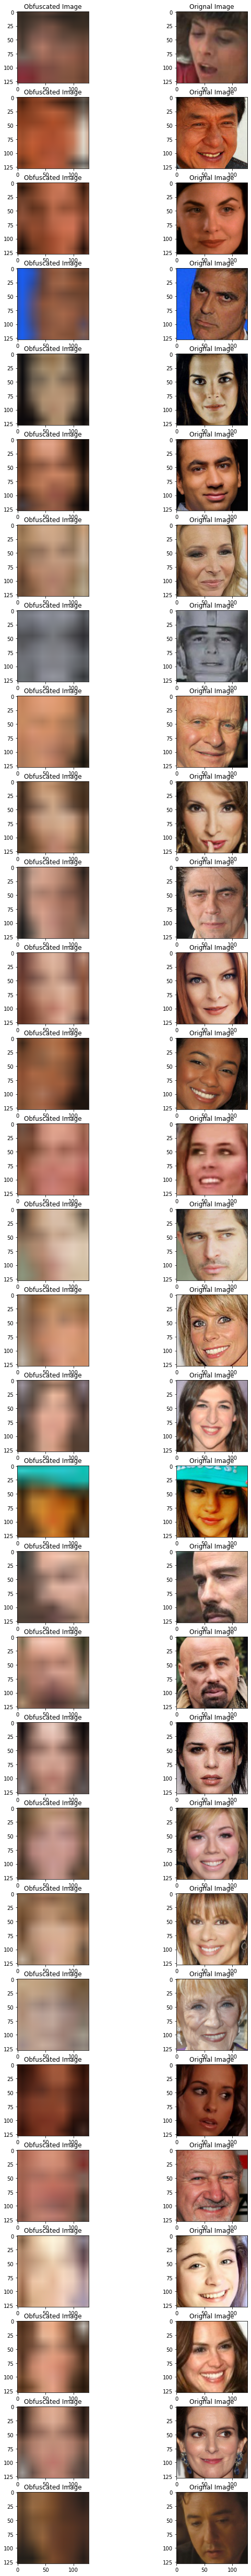

In [3]:
# filepath = 'C:/Users/13862/Desktop/Dataset/CelebA/'
# pathidentity=filepath+'Anno/CelebAIdentity512-459.pkl'

filepath = 'C:/Users/13862/Desktop/Dataset/'
pathidentity=filepath+'FaceScrubIdentity.pkl'

data = pd.read_pickle(pathidentity)
# df=data[data['identity']==0]
# dataframe=data[data['identity']==1]
# df=df.append(dataframe)
df=data
np.random.seed(33)
df = shuffle(df)
part=len(df)//10
print(part)
df_train = df[:int(8*part)]
df_test = df[int(8*part):int(9*part)]
df_val = df[int(9*part):]
size=128

face_dataset_train = CelebADataset(df_train,transform=transforms.Compose([
                                               Rescale(size,size,obfuscation=True),
                                               ObfuscaionToTensor()
                                           ]),obfuscation=True, sigma=9)
face_dataset_test = CelebADataset(df_test,transform=transforms.Compose([
                                               Rescale(size,size,obfuscation=True),
                                               ObfuscaionToTensor()
                                           ]),obfuscation=True, sigma=9)
face_dataset_val = CelebADataset(df_val,transform=transforms.Compose([
                                               Rescale(size,size,obfuscation=True),
                                               ObfuscaionToTensor()
                                           ]),obfuscation=True, sigma=9)

# face_dataset_train = CelebADataset(df_train,transform=transforms.Compose([
#                                                Rescale(128,128),
#                                                ToTensor()
#                                            ]))
# face_dataset_test = CelebADataset(df_test,transform=transforms.Compose([
#                                                Rescale(128,128),
#                                                ToTensor()
#                                            ]))
# face_dataset_val = CelebADataset(df_val,transform=transforms.Compose([
#                                                Rescale(128,128),
#                                                ToTensor()
#                                            ]))


fig, axs = plt.subplots(30, 2,figsize=(10,90))
grayscale = False
for i in range(len(face_dataset_train)):
    sample =  face_dataset_train[i]
    image=sample['image']
    obfus_image=sample['obfuscated']  
    image=image.float().detach().cpu()
    obfus_image=obfus_image.float().detach().cpu()
    if grayscale == False:
        axs[i, 0].imshow(np.transpose(obfus_image, (1, 2, 0)))
        axs[i, 0].set_title('Obfuscated Image')
        axs[i, 1].imshow(np.transpose(image, (1, 2, 0)))
        axs[i, 1].set_title('Orignal Image')
    else:
        axs[i, 0].imshow(np.transpose(obfus_image, (1, 2, 0)).squeeze(2), cmap=plt.get_cmap('gray'))
        axs[i, 0].set_title('Obfuscated Image')
        axs[i, 1].imshow(np.transpose(image, (1, 2, 0)).squeeze(2), cmap=plt.get_cmap('gray'))
        axs[i, 1].set_title('Orignal Image')
#     print(sample['labels'].numpy())
    if i == 29:
#         plt.show()
        break

In [63]:
# # filepath = 'C:/Users/13862/Desktop/Dataset/CelebA/'
# # pathidentity=filepath+'Anno/CelebAIdentity512-459.pkl'

# filepath = 'C:/Users/13862/Desktop/Dataset/'
# pathidentity=filepath+'FaceScrubIdentity.pkl'

# data = pd.read_pickle(pathidentity)
# # df=data[data['identity']==0]
# # dataframe=data[data['identity']==1]
# # df=df.append(dataframe)
# df=data
# np.random.seed(33)
# df = shuffle(df)
# part=len(df)//10
# print(part)
# df_train = df[:int(8*part)]
# df_test = df[int(8*part):int(9*part)]
# df_val = df[int(9*part):]
# size=128


# face_dataset_train = CelebADataset(df_train,transform=transforms.Compose([
#                                                Rescale(128,128),
#                                                ToTensor()
#                                            ]),Grayscale = False)
# face_dataset_test = CelebADataset(df_test,transform=transforms.Compose([
#                                                Rescale(128,128),
#                                                ToTensor()
#                                            ]),Grayscale = False)
# face_dataset_val = CelebADataset(df_val,transform=transforms.Compose([
#                                                Rescale(128,128),
#                                                ToTensor()
#                                            ]),Grayscale = False)

# fig, axs = plt.subplots(30, 1,figsize=(10,90))
# grayscale = False
# for i in range(len(face_dataset_train)):
#     sample =  face_dataset_train[i]
#     image=sample['image']
#     image=image.float().detach().cpu()
#     print(sample['labels'].numpy())

#     if grayscale == False:
#         axs[i].imshow(np.transpose(image, (1, 2, 0)))
#         axs[i].set_title(sample['labels'].numpy())
#     else:
#         axs[i].imshow(np.transpose(image, (1, 2, 0)).squeeze(2), cmap=plt.get_cmap('gray'))
#         axs[i].set_title(sample['labels'].numpy())
#     if i == 29:
# #         plt.show()
#         break

In [4]:
df

,identity,image_name
1420,28.0,C:/Users/13862/Desktop/AIOI-master/data/Facesc...
2983,58.0,C:/Users/13862/Desktop/AIOI-master/data/Facesc...
1510,30.0,C:/Users/13862/Desktop/AIOI-master/data/Facesc...
684,13.0,C:/Users/13862/Desktop/AIOI-master/data/Facesc...
2162,43.0,C:/Users/13862/Desktop/AIOI-master/data/Facesc...
...,...,...
57,0.0,C:/Users/13862/Desktop/AIOI-master/data/Facesc...
583,10.0,C:/Users/13862/Desktop/AIOI-master/data/Facesc...
5892,112.0,C:/Users/13862/Desktop/AIOI-master/data/Facesc...
2460,50.0,C:/Users/13862/Desktop/AIOI-master/data/Facesc...


In [64]:
batch_size=16
num_workers=0
dataloader = DataLoader(face_dataset_train, batch_size=batch_size,
                        shuffle=True, num_workers=num_workers)

dataloader_test = DataLoader(face_dataset_test, batch_size=batch_size,
                        shuffle=False, num_workers=num_workers)

dataloader_val = DataLoader(face_dataset_val, batch_size=batch_size,
                        shuffle=True, num_workers=num_workers)


In [65]:
from Discriminator_ResNet50 import ResNet200, Bottleneck
model=ResNet200(Bottleneck, [3, 4, 6, 3])


if train_on_gpu:
    model.cuda()

In [66]:
criterion = nn.CrossEntropyLoss()

# # # specify optimizer
# optimizer = optim.SGD(model.parameters(), lr=0.01)

# criterion = torch.nn.MSELoss()
# criterion = torch.nn.MSELoss(reduction = 'sum')
# discriminator_criterion = lpips.LPIPS(net='vgg').cuda()
# discriminator_criterion = lpips.LPIPS().cuda()
optimizer = torch.optim.Adam(model.parameters())


In [67]:
model

ResNet200(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(

In [68]:
model.load_state_dict(torch.load('classifier_obfp77.pt'))

<All keys matched successfully>

In [22]:
n_epochs = 30

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):
    torch.cuda.empty_cache()
    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for i_batch, sample_batched in enumerate(dataloader):
        images_batch,obfus_image_batch, labels_batch = \
                sample_batched['image'],sample_batched['obfuscated'], sample_batched['labels']
        img=images_batch.float()
        obf_image=obfus_image_batch.float()
        target = labels_batch.long()
        if train_on_gpu:
            img, obf_image, target = img.cuda(), obf_image.cuda(), target.cuda()
    
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        _,_,_,_,output = model(obf_image)
#         print(output)


        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*obf_image.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for i_batch, sample_batched in enumerate(dataloader_val):
        images_batch,obfus_image_batch, labels_batch = \
                sample_batched['image'],sample_batched['obfuscated'], sample_batched['labels']
        img=images_batch.float()
        obf_image=obfus_image_batch.float()
        target = labels_batch.long()
        if train_on_gpu:
            img, obf_image, target = img.cuda(), obf_image.cuda(), target.cuda()
            
        _,_,_,_,output = model(obf_image)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*obf_image.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(dataloader)
    valid_loss = valid_loss/len(dataloader_val)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = valid_loss




Epoch: 1 	Training Loss: 29.643077 	Validation Loss: 48.701771
Validation loss decreased (inf --> 48.701771).  Saving model ...
Epoch: 2 	Training Loss: 19.678707 	Validation Loss: 46.831803
Validation loss decreased (48.701771 --> 46.831803).  Saving model ...
Epoch: 3 	Training Loss: 14.364089 	Validation Loss: 46.472906
Validation loss decreased (46.831803 --> 46.472906).  Saving model ...
Epoch: 4 	Training Loss: 10.170102 	Validation Loss: 50.078555
Epoch: 5 	Training Loss: 7.761452 	Validation Loss: 52.164083


KeyboardInterrupt: 

In [57]:
from Image_reconstructor_res import Encoder_Decoder_Residual
from Discrimnator_ResNet import ResNet, Bottleneck
Discriminator_compare=ResNet(Bottleneck, [3, 4, 6, 3])
Discriminator_compare.load_state_dict(torch.load('Discriminator_ResNet50NEW.pt'))
for param in Discriminator_compare.parameters():
    param.requires_grad = False

if train_on_gpu:
    Discriminator_compare.cuda()

model = Encoder_Decoder_Residual(Discriminator_compare)
model.load_state_dict(torch.load('Image_reconstructor_res_doubleloss_pixel77.pt'))
for param in model.parameters():
    param.requires_grad = False

if train_on_gpu:
    model.cuda()

In [58]:
from Discriminator_ResNet50 import ResNet200, Bottleneck
classfier=ResNet200(Bottleneck, [3, 4, 6, 3])


if train_on_gpu:
    classfier.cuda()

In [59]:
classfier.load_state_dict(torch.load('classifier_res_p77.pt'))

<All keys matched successfully>

In [69]:
test_loss = 0.0
# class_correct = list(0. for i in range(20))
# class_total = list(0. for i in range(20))
acc=0
counter=0
counter1=0
batch_size=16
model.eval()
# iterate over test data
for i_batch, sample_batched in enumerate(dataloader_test):
    images_batch,obfus_image_batch, labels_batch = \
                sample_batched['image'],sample_batched['obfuscated'], sample_batched['labels']
    img=images_batch.float()
    obf_image=obfus_image_batch.float()
    target = labels_batch.long()
    if train_on_gpu:
        img, obf_image, target = img.cuda(), obf_image.cuda(), target.cuda()
#     output = get_features(data,discriminator)
#     output = output['out']
#     output1,_ = model(obf_image)
#     _,_,_,_,output = classfier(output1)
#     print(output)
    # calculate the batch loss
#     loss = criterion(output, target.view(-1, 1).float())
    _,_,_,_,output = model(obf_image)
    loss = F.cross_entropy(output, target)
    # update test loss 
    test_loss += loss.item()*obf_image.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    counter1=counter1+1
    if counter1==1080//batch_size:
        break
    for i in range(batch_size):
        counter=counter+1
        if correct[i]==True:
            acc=acc+1
        
        
       
test_loss = test_loss/len(dataloader_test)
print('Test Loss: {:.6f}\n'.format(test_loss))


print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * acc / counter,
    acc, counter))


Test Loss: 45.621455


Test Accuracy (Overall): 42% (453/1056)


In [75]:
# def get_features(image, model, layers=None):
#     """ Run an image forward through a model and get the features for 
#         a set of layers. Default layers are for VGGNet matching Gatys et al (2016)
#     """
    
#     ## TODO: Complete mapping layer names of PyTorch's VGGNet to names from the paper
#     ## Need the layers for the content and style representations of an image
#     if layers is None:
#         layers = {'layer4':'loss',
#                   'fc': 'out'}
        
#     features = {}
#     x = image
#     # model._modules is a dictionary holding each module in the model
            
#     for name, layer in discriminator._modules.items():
#         if name=='fc':
#             x=x.view(1, -1)
# #             print(x.size())
#         x = layer(x)
# #         print(x.size())
        
#         if name in layers:
#             features[layers[name]] = x
            
#     return features

In [53]:
# dataloader_test = DataLoader(face_dataset_test, batch_size=1,
#                         shuffle=False, num_workers=num_workers)

IndexError: index 10 is out of bounds for dimension 0 with size 10

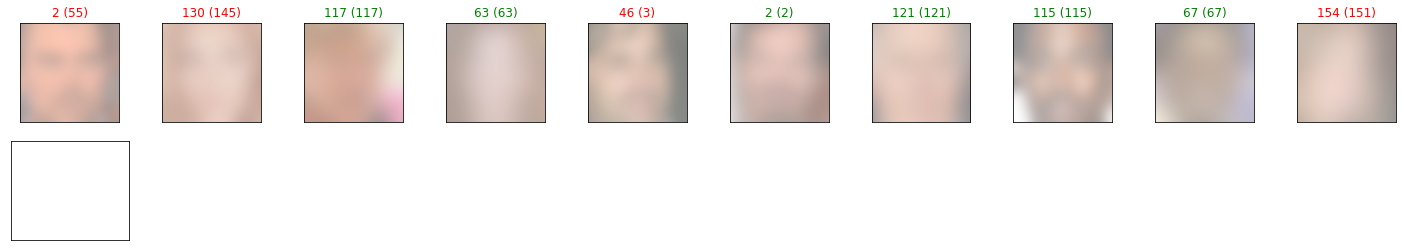

In [46]:

    
for i_batch, sample_batched in enumerate(dataloader_test):
    if i_batch==136:
        break
    images_batch, landmarks_batch = \
            sample_batched['obfuscated'], sample_batched['labels']
    images=images_batch.float()
    images.numpy()
    labels = landmarks_batch.long()

if train_on_gpu:
    images = images.cuda()


_,_,_,_,output = model(images)

# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images.cpu()[idx])
    ax.set_title("{} ({})".format(preds[idx], labels[idx]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))
# for idx in np.arange(batch_size):
#     ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
#     imshow(images.cpu()[idx])
#     ax.set_title("{} ({})".format(preds[idx], labels[idx]),
#                  color=("green" if preds[idx]==labels[idx].item() else "red"))

10907


Obfuscated Image Reconstructor